###1. Implement the following layers as python functions(both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

###2. Implement training and testing process
* included cross-validation

###3. Plot epoch-accuracy curves


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cd /content/drive/MyDrive/AI_Lab1
%cd /content/drive/MyDrive/Colab Notebooks/AI_lab1

/content/drive/MyDrive/Colab Notebooks/AI_lab1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [17]:
# load MNIST dataset
image_size = 28           # width and length
no_of_different_labels = 10     #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",")
# data preprocessing

# map pixels information from range(0, 255) to range(0.01, 1)
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

print(train_imgs.shape)
train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float64)
test_labels_one_hot = (lr==test_labels).astype(np.float64)




(60000, 784)


分出validation set

In [37]:
N = len(train_imgs)                 # number of sample
val_split = 0.2                   # validation split
train_N = int(N * (1 - val_split))        # Train數量
train_val = int(N * val_split)           # Validation數量

x_train = train_imgs[:train_N]
y_train = train_labels_one_hot[:train_N]
x_val= train_imgs[train_N:]
y_val= train_labels_one_hot[train_N:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


Function

In [38]:
def relu(x, leak = 0):
    return np.where(x <= 0, leak * x, x)
def softmax(x):
  return np.exp(x)/np.sum(np.exp(x))
def cross_E(y_true,y_pred):
  return -np.sum(y_true*np.log(y_pred+10**-100))
#===================================================
def cross_E_grad(y_true,y_pred):
  return -y_true/(y_pred+10**-100)
def softmax_dash(x):
  I=np.eye(x.shape[0])
  return softmax(x)*(I-softmax(x).T)
def relu_dash(x, leak = 0):
    return np.where(x <= 0, leak, 1)

訓練前設置

In [72]:
# 將資料型態轉為float128(64不夠計算，會在exp的時候結果為NaN)
x_train=np.array(x_train,dtype=np.float128)
y_train=np.array(y_train,dtype=np.float128)
x_val=np.array(x_val,dtype=np.float128)
y_val=np.array(y_val,dtype=np.float128)

# reshape data
x_train=x_train.reshape(len(x_train),784,1)
y_train=y_train.reshape(len(y_train),10,1)
x_val=x_val.reshape(len(x_val),784,1)
y_val=y_val.reshape(len(y_val),10,1)

# layer設定
np.random.seed(5)
input_nodes=784
hidden_1_nodes=15
output_nodes=10

# w,b初始化
w1 = np.random.random(size = (hidden_1_nodes, input_nodes))
b1 = np.zeros(shape = (hidden_1_nodes, 1))

w2 = np.random.random(size = (output_nodes, hidden_1_nodes))
b2 = np.zeros(shape = (output_nodes, 1))

# sgd初始化
learning_rate = 0.01
update_w1 = np.zeros(w1.shape)
update_b1 = np.zeros(b1.shape)
update_w2 = np.zeros(w2.shape)
update_b2 = np.zeros(b2.shape)

模型訓練

In [73]:
epochs=70
batch_size = 100
number_batches = int(train_N/batch_size)

loss_accumulator = []
acc_accumulator = []
val_loss_accumulator = []
val_acc_accumulator=[]
#==================================================================================
for epoch in range(epochs):
  avg_loss=0
  avg_acc=0
  for batch in range(number_batches):
    loss=0
    acc=0
    sample=batch*batch_size
    grad_w2 = 0
    grad_b2 = 0

    grad_w1 = 0
    grad_b1 = 0

    for iteration in range(batch_size):
      #forward
      in_hidden_1=w1.dot(x_train[sample])+b1
      out_hidden_1=relu(in_hidden_1)

      in_output_layer=w2.dot(out_hidden_1)+b2
      y_hat=softmax(in_output_layer)

      loss+=cross_E(y_train[sample],y_hat)

      if(np.argmax(y_train[sample])==np.argmax(y_hat)):
        acc+=1


      #backward
      error_upto_softmax =(y_hat-y_train[sample]).reshape((-1,1))
      grad_w2+=error_upto_softmax.dot(out_hidden_1.T)
      grad_b2+=error_upto_softmax

      error_grad_H1=np.sum(error_upto_softmax*w2,axis=0).reshape((-1,1))
      grad_w1+=error_grad_H1*relu_dash(in_hidden_1).dot(x_train[sample].T)
      grad_b1+=error_grad_H1*relu(in_hidden_1)

      sample+=1
    #更新W B
    update_w1=-learning_rate * (grad_w1/batch_size)
    w1+=update_w1

    update_b1=-learning_rate * (grad_b1/batch_size)
    b1+=update_b1

    update_w2=-learning_rate * (grad_w2/batch_size)
    w2+=update_w2

    update_b2=-learning_rate * (grad_b2/batch_size)
    b2+=update_b2
    # 計算平均一個batch的loss和accuracy
    avg_loss+=loss/batch_size
    avg_acc+=acc/batch_size


  print(f'=======================epoch{epoch+1}=======================')
  print(f'avg loss = {avg_loss/number_batches}')
  print(f'avg accuracy = {avg_acc/number_batches}')
  print("---------------------------------")
  #每個epoch對應的acc/loss 畫圖用
  acc_accumulator.append(avg_acc/number_batches)
  loss_accumulator.append(avg_loss/number_batches)

  #validation
  val_loss=0
  val_acc=0
  for val in range(train_val):
    in_hidden_1 = w1.dot(x_val[val]) + b1
    out_hidden_1 = relu(in_hidden_1)
    in_output_layer = w2.dot(out_hidden_1) + b2
    y_hat = softmax(in_output_layer)
    #validation loss
    val_loss += cross_E(y_val[val], y_hat)
    if(np.argmax(y_val[val])==np.argmax(y_hat)):
      val_acc+=1

  print(f'avg validation loss={val_loss/(val + 1)}')
  print(f'avg validation accuracy={val_acc/(val + 1)}')
  #每個epoch對應的acc/loss 畫圖用
  val_acc_accumulator.append(val_acc/(val + 1))
  val_loss_accumulator.append(val_loss/(val + 1))
  print('===================================================')
  print('\n')












=======================epoch1=======================
avg loss = 44.49717099865156
avg accuracy = 0.30341666666666695
---------------------------------
avg validation loss=7.4234701437214445
avg validation accuracy=0.5124166666666666


=======================epoch2=======================
avg loss = 2.6053866142753095
avg accuracy = 0.6708333333333333
---------------------------------
avg validation loss=2.2797157962249144
avg validation accuracy=0.7054166666666667


=======================epoch3=======================
avg loss = 1.3343123020332674
avg accuracy = 0.7600625000000001
---------------------------------
avg validation loss=1.0640194665886984
avg validation accuracy=0.77025


=======================epoch4=======================
avg loss = 1.0626936404550247
avg accuracy = 0.7956458333333338
---------------------------------
avg validation loss=0.8848450981898484
avg validation accuracy=0.7999166666666667


=======================epoch5=======================
avg loss = 0.89871

Test

In [76]:
# reshape data
test_imgs=test_imgs.reshape(len(test_imgs),784,1)
test_labels_one_hot=test_labels_one_hot.reshape(len(test_labels_one_hot),10,1)

test_acc=0
print(len(test_imgs))
for sample in range(len(test_imgs)):
  in_hidden_1=w1.dot(x_train[sample])+b1
  out_hidden_1=relu(in_hidden_1)

  in_output_layer=w2.dot(out_hidden_1)+b2
  y_hat=softmax(in_output_layer)


  if(np.argmax(y_train[sample])==np.argmax(y_hat)):
    test_acc+=1

print(f'test accuracy={test_acc/len(test_imgs)}')

10000
test accuracy=0.9073


訓練loss圖

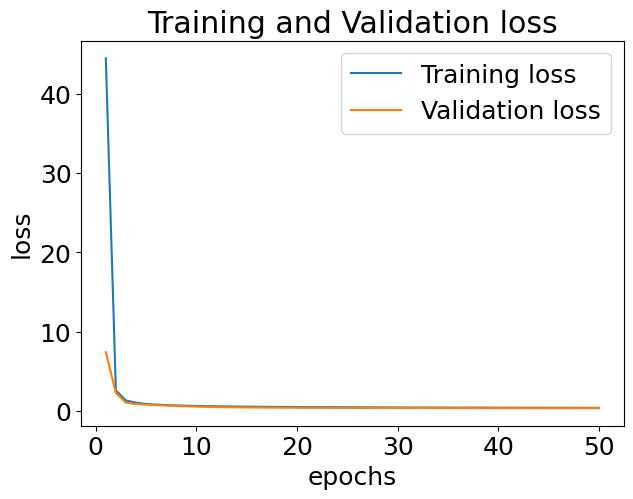

In [66]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
EPOCH = [i for i in range(1, epochs + 1)]
fig = plt.figure(figsize=(7,5))

ax = plt.axes()
ax.plot(EPOCH, loss_accumulator, label='Training loss')
ax.plot(EPOCH, val_loss_accumulator, label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
ax.set_title('Training and Validation loss')
ax.legend()
plt.show()

訓練acc圖

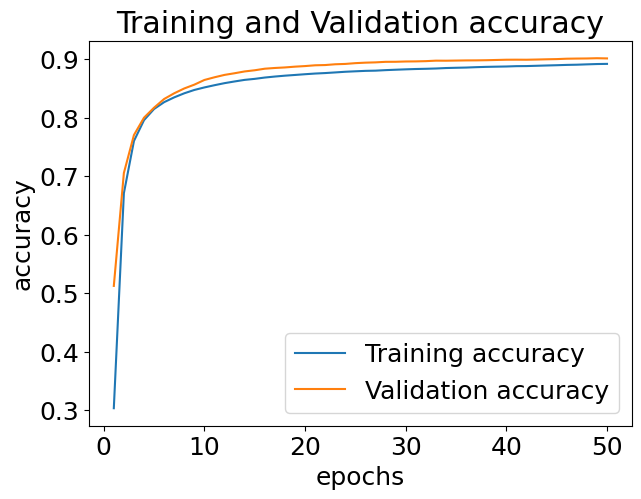

In [68]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
EPOCH = [i for i in range(1, epochs + 1)]
fig = plt.figure(figsize=(7,5))

ax = plt.axes()
ax.plot(EPOCH, acc_accumulator, label='Training accuracy')
ax.plot(EPOCH, val_acc_accumulator, label='Validation accuracy')
plt.xlabel("epochs")                  #設定x座標標題及粗體
plt.ylabel("accuracy")
ax.set_title('Training and Validation accuracy')
ax.legend()
plt.show()

In [ ]:
# Using test_images and test_labels to do the final test

In [ ]:
# plot accuracy and loss curves
